# Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!nvidia-smi

In [ ]:
import numpy as np
import random
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create the model

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.GELU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.gelu = nn.GELU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.gelu(out)
        return out


In [ ]:
class ParallelModel(nn.Module):
    def __init__(self, block, layers, num_emotions):
        super().__init__()

        # Resnet Block
        self.inplanes = 64
        self.res_conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.GELU())
        self.res_maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.res_layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.res_layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.res_layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.res_layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.res_avgpool = nn.AvgPool2d(3, stride=1)
#         self.res_fc = nn.Linear(512, num_emotions)

        # Block 1:
        self.conv1 = nn.Conv2d(in_channels=1,
                    out_channels=16,
                    kernel_size=3,
                    stride=1,
                    padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.3)

        # Block 2:
        self.conv2 = nn.Conv2d(in_channels=16,
                    out_channels=32,
                    kernel_size=3,
                    stride=1,
                    padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.max_pool2 = nn.MaxPool2d(kernel_size=4, stride=4)

        # Block 3:
        self.conv3 = nn.Conv2d(in_channels=32,
                    out_channels=64,
                    kernel_size=3,
                    stride=1,
                    padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.max_pool3 = nn.MaxPool2d(kernel_size=4, stride=4)

        # Block 4:
        self.conv4 = nn.Conv2d(in_channels=64,
                    out_channels=64,
                    kernel_size=3,
                    stride=1,
                    padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.max_pool4 = nn.MaxPool2d(kernel_size=4, stride=4)

        # LSTM block
        self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        hidden_size = 148
        self.lstm = nn.LSTM(input_size=74,hidden_size=hidden_size,bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(0.1)
        self.attention_linear = nn.Linear(2*hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM

        # Transformer block
        self.transf_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])
        transf_layer = nn.TransformerEncoderLayer(d_model=148, nhead=4, dim_feedforward=512, dropout=0.4, activation='relu')
        self.transf_encoder = nn.TransformerEncoder(transf_layer, num_layers=4)
        # Linear softmax layer
        self.out_linear = nn.Linear(2*hidden_size+212+15360,num_emotions)
        self.dropout_linear = nn.Dropout(p=0)
        self.out_softmax = nn.Softmax(dim=1)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self,x):

        # resnet embedding
        res_embedding = self.res_conv1(x)
        res_embedding = self.res_maxpool(res_embedding)
        res_embedding = self.res_layer0(res_embedding)
        res_embedding = self.res_layer1(res_embedding)
        res_embedding = self.dropout(res_embedding)
        res_embedding = self.res_layer2(res_embedding)
        res_embedding = self.res_layer3(res_embedding)
        res_embedding = self.dropout(res_embedding)

        # res_embedding = self.res_avgpool(res_embedding)
        res_embedding = res_embedding.view(res_embedding.size(0), -1)

        # conv embedding
#         conv_embedding = self.conv2Dblock(x) #(b,channel,freq,time)
        conv_embedding = self.dropout(self.max_pool1(self.relu(self.bn1(self.conv1(x)))))
        conv_embedding = self.dropout(self.max_pool2(self.relu(self.bn2(self.conv2(conv_embedding)))))
        conv_embedding = self.dropout(self.max_pool3(self.relu(self.bn3(self.conv3(conv_embedding)))))
        conv_embedding = self.dropout(self.max_pool4(self.relu(self.bn4(self.conv4(conv_embedding)))))

        conv_embedding = torch.flatten(conv_embedding, start_dim=1) # do not flatten batch dimension

        # lstm embedding
        x_reduced = self.lstm_maxpool(x)
        x_reduced = torch.squeeze(x_reduced,1)
        x_reduced = x_reduced.permute(0,2,1) # (batch,time,freq)
        lstm_embedding, (h,c) = self.lstm(x_reduced) # (b, time, hidden_size*2)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        batch_size,T,_ = lstm_embedding.shape
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_embedding[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
        attention = torch.bmm(attention_weights_norm,lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)


        # transformer embedding
        x_reduced_t = self.transf_maxpool(x)
        x_reduced_t = torch.squeeze(x_reduced_t,1)
        x_reduced_t = x_reduced_t.permute(2,0,1) # (time,batch,embedding)
        transf_out = self.transf_encoder(x_reduced_t)
        transf_embedding = torch.mean(transf_out, dim=0)
        # concatenate
        complete_embedding = torch.cat([res_embedding, conv_embedding, attention, transf_embedding], dim=1)
        # final Linear
        output_logits = self.out_linear(complete_embedding)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax


In [ ]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

# TRAINING

In [ ]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [ ]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

scale data

In [ ]:
X_train = np.load(file="/content/drive/MyDrive/serdl/notebooks/3_dataset_mel/xtrain.npy")
X_test = np.load(file="/content/drive/MyDrive/serdl/notebooks/3_dataset_mel/xtest.npy")
X_val = np.load(file="/content/drive/MyDrive/serdl/notebooks/3_dataset_mel/xval.npy")

Y_train = np.load(file="/content/drive/MyDrive/serdl/notebooks/3_dataset_mel/ytrain.npy")
Y_test = np.load(file="/content/drive/MyDrive/serdl/notebooks/3_dataset_mel/ytest.npy")
Y_val = np.load(file="/content/drive/MyDrive/serdl/notebooks/3_dataset_mel/yval.npy")

X_train.shape

Train the model

In [ ]:
import copy

In [ ]:
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'}
EPOCHS=200
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = ParallelModel(ResidualBlock, [2,2,2,2], len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()))
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)
# OPTIMIZER = torch.optim.Adam(model.parameters(),lr=0.01, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(OPTIMIZER, gamma=0.99)

# Early Stopping Criterion
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
no_improve_epochs = 0
patience = 20

# Warmup
WARMUP_EPOCHS = 10
ORIGINAL_LR = 0.01
START_LR = 1e-4
increment_lr = (ORIGINAL_LR - START_LR) / WARMUP_EPOCHS

for g in OPTIMIZER.param_groups: # update optimizer with start_lr
    g['lr'] = START_LR

# Training
train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)
losses=[]
val_losses = []
start = time.time()
for epoch in range(EPOCHS):
    if epoch < WARMUP_EPOCHS:
        # increase lr
        lr = START_LR + epoch * increment_lr
        # update lr
        for g in OPTIMIZER.param_groups:
            g['lr'] = lr

    # schuffle data
    start_epoch = time.time()
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, predictions = validate(X_val_tensor,Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    scheduler.step()

    if val_acc > best_acc:
        best_acc = val_acc
        no_improve_epochs = 0
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= patience:
        print(f'Early stopping after {epoch+1} epochs')
        break


    elapsed_epoch = time.time() - start_epoch
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, "
        f"val_acc:{val_acc:.2f}%, time:{elapsed_epoch:.2f}sec")
    print(f'Epoch {epoch}: Learning Rate: {OPTIMIZER.param_groups[0]["lr"]:.6f}')


Selected device is cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Number of trainable params:  12589569
 Epoch 0: iteration 175/176
Epoch 0 --> loss:2.0988, acc:19.53%, val_loss:1.6515, val_acc:42.89%, time:11.20sec
Epoch 0: Learning Rate: 0.000099
 Epoch 1: iteration 175/176
Epoch 1 --> loss:1.8496, acc:33.89%, val_loss:0.9413, val_acc:65.82%, time:10.22sec
Epoch 1: Learning Rate: 0.001079
 Epoch 2: iteration 175/176
Epoch 2 --> loss:1.6052, acc:41.55%, val_loss:0.8637, val_acc:67.73%, time:10.18sec
Epoch 2: Learning Rate: 0.002059
 Epoch 3: iteration 175/176
Epoch 3 --> loss:1.4740, acc:45.08%, val_loss:0.8437, val_acc:70.49%, time:10.19sec
Epoch 3: Learning Rate: 0.003039
 Epoch 4: iteration 175/176
Epoch 4 --> loss:1.3184, acc:50.41%, val_loss:0.8809, val_acc:71.13%, time:10.20sec
Epoch 4: Learning Rate: 0.004019
 Epoch 5: iteration 175/176
Epoch 5 --> loss:1.3319, acc:53.42%, val_loss:1.1791, val_acc:63.91%, time:10.14sec
Epoch 5: Learning Rate: 0.004999
 Epoch 6: iteration 175/176
Epoch 6 --> loss:1.2189, acc:57.71%, val_loss:1.4917, val_acc:68

In [ ]:
elapsed = time.time() - start
print(f"Total training time:{elapsed:.2f}sec")

# Save model

In [ ]:
SAVE_PATH = os.path.join(os.getcwd(),'/content/drive/MyDrive/serdl/notebooks/new_models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'big_ctrl_mel_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'big_ctrl_mel_model.pt')))

# Load model

In [ ]:
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))

LOAD_PATH = os.path.join(os.getcwd(),'/content/drive/MyDrive/serdl/notebooks/new_models')
model = ParallelModel(ResidualBlock, [2,2,2,2], len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'big_ctrl_mel_model.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'big_ctrl_mel_model.pt')))

# Test

In [ ]:
model.to(device)
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)
# OPTIMIZER = torch.optim.Adam(model.parameters(),lr=0.01, weight_decay=1e-3)
train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)

start = time.time()
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
elapsed = time.time() - start
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')
print(f"Total test time:{elapsed:.3f}sec")

Test loss is 1.377
Test accuracy is 80.33%
Total test time:0.093sec


confusion matrix

F1-Score: 0.803347280334728


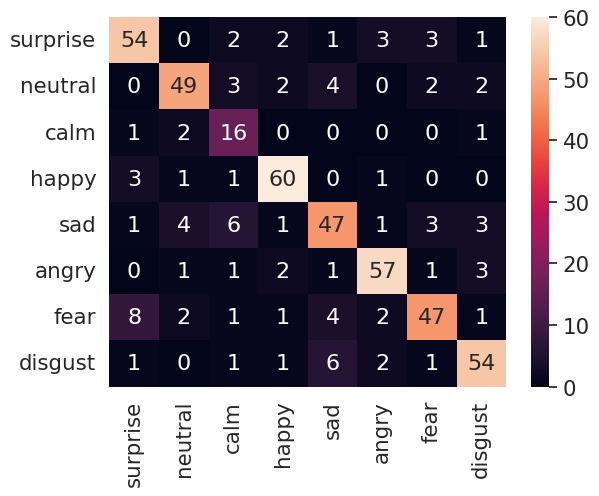

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
f1 = f1_score(Y_test, predictions, average='micro')
print("F1-Score:", f1)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

# Plot loss

In [ ]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])